# Rigid Stellar Rotation and Gaussian Convolution

In [ ]:
import numpy as np
from exojax.spec.rtransfer import nugrid
from exojax.spec import response

In [2]:
nus,wav,res=nugrid(23000,23100,2000,unit="AA")

In [3]:
#1 - delta function like
F=np.ones_like(nus)
F[1000]=0.0

In [4]:
vsini=100.0 #km/s

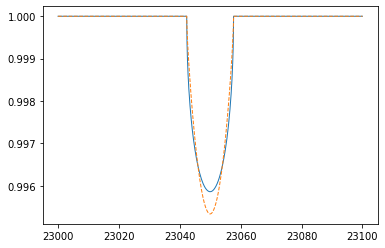

In [6]:
import matplotlib.pyplot as plt
plt.plot(wav,response.rigidrot(nus,F,vsini,u1=0.0,u2=0.0),lw=1)
plt.plot(wav,response.rigidrot(nus,F,vsini,u1=0.6,u2=0.4),lw=1,ls="dashed")
plt.show()

Gaussian covolution and velocity shift

In [7]:
beta=20.0 #std of gaussian
Frot=response.rigidrot(nus,F,vsini,u1=0.0,u2=0.0)
Fx=response.ipgauss_sampling(nus,nus,Frot,20.0,0.0)
Fxx=response.ipgauss_sampling(nus,nus,Frot,50.0,30.0)

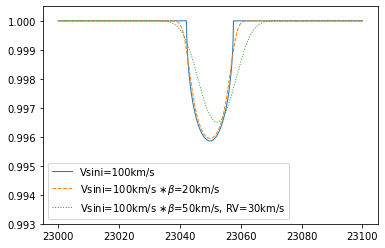

In [8]:
plt.plot(wav[::-1],Frot,lw=1,label="Vsini=100km/s")
plt.plot(wav[::-1],Fx,lw=1,ls="dashed",label="Vsini=100km/s $\\ast \\beta$=20km/s")
plt.plot(wav[::-1],Fxx,lw=1,ls="dotted",label="Vsini=100km/s $\\ast \\beta$=50km/s, RV=30km/s")
plt.legend(loc="lower left")
plt.ylim(0.993,1.0005)
plt.show()

In [9]:
#summation is conserved
print(np.sum(F))
print(np.sum(response.rigidrot(nus,F,vsini,u1=0.6,u2=0.4)))
print(np.sum(response.rigidrot(nus,F,vsini,u1=0.0,u2=0.0)))
print(np.sum(Fx))

1999.0
1999.0
1999.0
1999.0


## derivative 

In [27]:
from jax import grad, jit
import jax.numpy as jnp

In [33]:
@jit
def rigidrot(nus,F0,vsini,u1=0.0,u2=0.0):
    cpvsini=299792.458/vsini
    x=jnp.array(cpvsini*jnp.log(nus[None,:]/nus[:,None]))
    x2=x*x
    kernel=jnp.where(x2<1.0,jnp.pi/2.0*u1*(1.0 - x2) - 2.0/3.0*jnp.sqrt(1.0-x2)\
*(-3.0+3.0*u1+u2+2.0*u2*x2),0.0)
    kernel=kernel/jnp.sum(kernel,axis=0) #axis=N                                
    F=kernel.T@F0

    return F


In [34]:
def obj(vsini):
    frott=rigidrot(nus,F,vsini,u1=0.0,u2=0.0)
    d=frott-Frot
    return jnp.dot(d,d)

In [35]:
dobj=grad(obj,argnums=0)

In [36]:
obj(10.0)

DeviceArray(0.03023948, dtype=float32)

In [32]:
dobj(10.0)

DeviceArray(nan, dtype=float32)